# Сегментация пользователей банка

***Основная цель:*** Определение значений параметров, характерных для группы пользователей, переставших пользоваться услугами банка. 

***Для кого и зачем:*** Для менеджеров, принимающих решения о развитии продуктов банка и стремящихся повысить долю лояльных клиентов.

***Что сделаем:***
- сделаем [общий обзор](#info_id) данных;
- исследуем наличие зависимости между [количеством продуктов и оттоком](#products_id);
- посмотрим, есть ли зависимость между [кредитным рейтингом и оттоком](#score_id);
- посмотрим, какие доли оттока демонстрируют [разные города](#city_id);
- узнаем, влияет ли [возрастная группа на отток](#age_id);
- проанализируем наличие взаимосвязи между [количеством объектов и оттоком](#objects_id);
- оценим, как влияет [баланс на счете клиента на отток](#balance_id);
- определим влияние [уровня зарплаты на отток](#salary_id);
- рассмотрим [доли оттока у клиентов, имеющих кредитную карту и не имеющих такой](#credit_card_id);
- проведем [сегментацию клиентов](#segmentation_id) по количеству используемых ими продуктов;
- в завершении [проверим несколько статистических гипотез](#stat_tests_id) и сформулируем [выводы](#summary_id).

***Презентация по проекту:*** <a href="https://disk.yandex.ru/i/txLSWbRl8yRcug">посмотреть.</a>
    
***Дашборд в Tableau Public:*** <a href="https://public.tableau.com/app/profile/danil6496/viz/Bank_16693167366810/Dashboard1?publish=yes">посмотреть</a>.

## Знакомство с данными

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth

sns.set(rc={'figure.figsize':(11.7,8.27)})

Загрузим исходные данные и посмотрим первые 5 строк.

In [2]:
df = pd.read_csv(r'https://code.s3.yandex.net/datasets/bank_dataset.csv')
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


<a id='info_id'></a>

Посмотрим общую информацию о данных.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


- Всего в нашей выборке 10 тысяч записей;
- Пропуски есть только в колонке `Balance`. Пропущено около 1/3 значений;
- Типы данных логично соответствуют информации в колонках. Можно понять тип только в столбцах `CreditCard`, `Loyalty` и `Churn` с int на bool;
- Названия столбцов для удобства необходимо привести в "змеиному" регистру.

Теперь посмотрим на разброс численных признаков.

In [4]:
# отключим scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,"10,000.00","15,733,676.57","71,936.19","15,608,437.00","15,671,264.25","15,733,474.00","15,795,969.75","15,858,426.00"
score,"10,000.00",650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,"10,000.00",38.92,10.49,18.00,32.00,37.00,44.00,92.00
Objects,"10,000.00",5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,"6,383.00","119,827.49","30,095.06","3,768.69","100,181.98","119,839.69","139,512.29","250,898.09"
Products,"10,000.00",1.53,0.58,1.00,1.00,1.00,2.00,4.00
CreditCard,"10,000.00",0.71,0.46,0.00,0.00,1.00,1.00,1.00
Loyalty,"10,000.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
estimated_salary,"10,000.00","100,090.24","57,510.49",11.58,"51,002.11","100,193.91","149,388.25","199,992.48"
Churn,"10,000.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00


- Разброс кредитного рейтинга: от 350 до 850. Половина пользователей - с рейтингом выше 652;
- Разброс возраста: от 18 до 92. Половина пользователей - старше 37;
- Разброс количества объектов: от 0 до 10. Половина пользователей имеет больше 5 объектов;
- Разброс баланса: от 3,8 тысяч до 250,9 тысяч. Половина пользователей, у которых указан баланс, - с балансом больше 119,8 тысяч;
- Разброс количества продуктов: от 1 до 4. Половина пользователей пользуется только 1 продуктом;
- Разброс зарплат: от 11 до 119992. Половина пользователей имеет зарплату больше 100 тысяч. Стоит обратить внимание на неестественно маленькие показатели в столбце зарплат.

## Предобработка данных

Приведем названия столбцов к "змеиному" регистру.

In [5]:
df.columns = [i.lower() for i in df.columns]
df = df.rename(columns={'userid': 'user_id',
                        'creditcard': 'credit_card'}) 

Поменяем тип в столбцах `credit_card`, `loyalty` и `churn` с int на bool.

In [6]:
df[['credit_card', 'loyalty', 'churn']] = df[['credit_card', 'loyalty', 'churn']].astype(bool)

Посмотрим на количество пропусков в столбце `balance`.

In [7]:
df['balance'].isna().sum()

3617

- Около трети значений в этом столбце пропущено;
- Менять пропуски на нули не будем, так как это может исказить данные. Возможно, клиент пользуется кредитной картой, но у него нет дебетовой, поэтому не баланс нулевой, а счета нет совсем.

Посмотрим нет ли в наших данных дубликатов.

In [8]:
df.duplicated().sum()

0

- Явных дубликатов нет. 

Проверим еще, нет ли пользователей, которые в наших данных повторяются.

In [9]:
df['user_id'].nunique()

10000

- Повторяющихся пользователей тоже нет.

## Исследовательский анализ данных

Построим на распределения каждого признака.

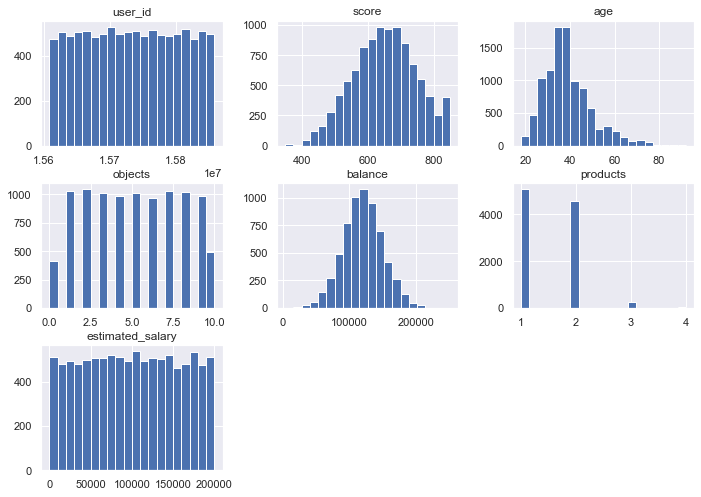

In [10]:
df.hist(bins=20);

С пощощью "ящиков с усами" посмотрим на наличие выбросов.

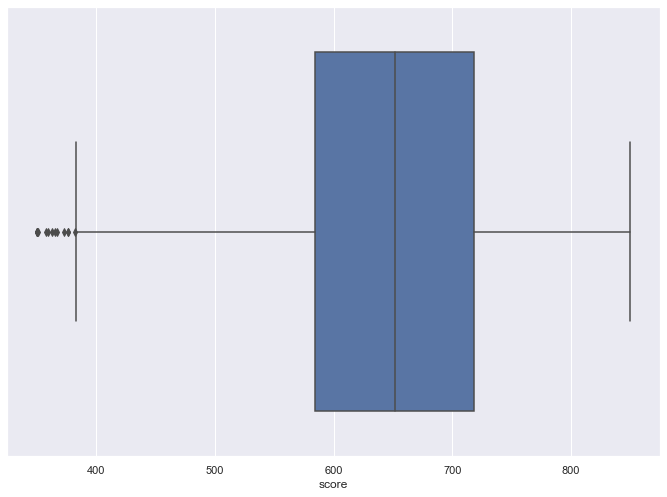

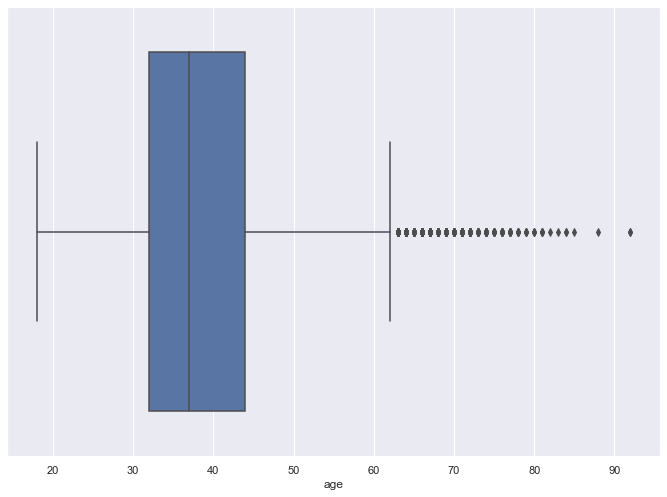

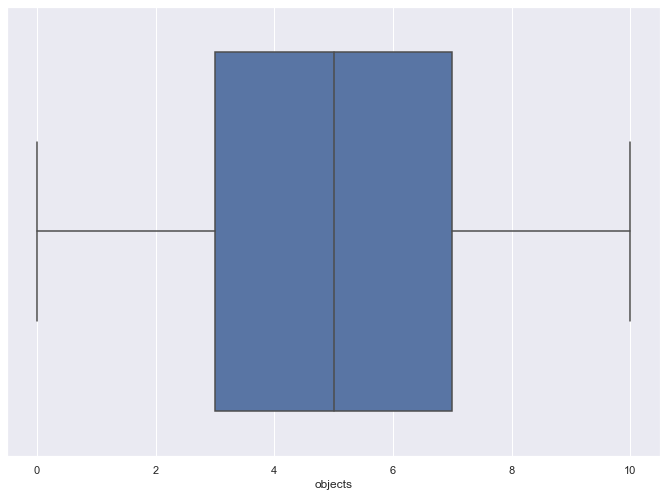

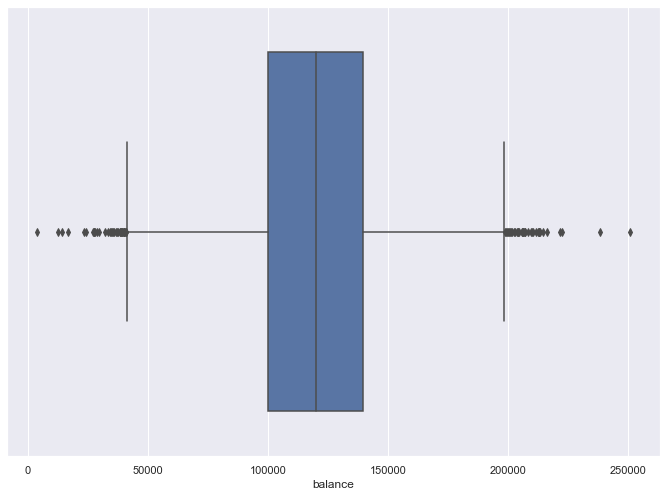

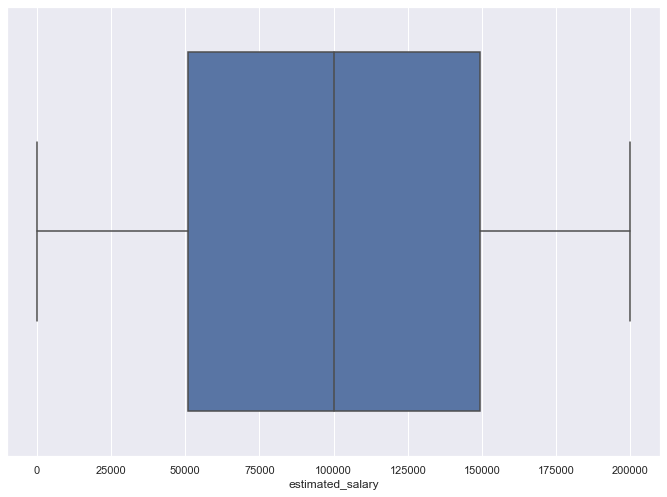

In [11]:
for col in ['score', 'age', 'objects', 'balance', 'estimated_salary']:
    sns.boxplot(x=df[col], orient='h')
    plt.show()

- У нас есть несколько выбивающихся значений низкого кредитного рейтинга;
- Редко возраст клиентов превышает 60 лет.

Посмотрим на точные цифры разбивки пользователей по количеству продуктов:

In [12]:
df['products'].value_counts()

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

Посмотрим на 5-процентный перцентиль по зарплате:

In [13]:
df.estimated_salary.quantile(0.05)

9851.818500000001

Посмотрим на распределение пользователей по признакам наличия кредитной карточки, активности и оттока:

In [14]:
for col in ['credit_card', 'loyalty', 'churn']:
    print(col)
    print(df[col].value_counts(normalize=True), end='\n\n')

credit_card
True                    0.71
False                   0.29
Name: credit_card, dtype: float64

loyalty
True                    0.52
False                   0.48
Name: loyalty, dtype: float64

churn
False                   0.80
True                    0.20
Name: churn, dtype: float64



***Выводы:***

- Распределение кредитного рейтинга похоже на нормальное со смещением вправо: у нас довольно много больших рейтингов и почти нет маленьких;
- Распределение возраста тоже похоже на нормальное, но со смещением влево: у нас довольно много молодых пользователей и почти нет тех, кому за 60;
- Примерно равное количество пользователей владеет 1-9 объектами - около 1000 пользователей в каждой группе. Примерно в два раза меньше пользователей в группах совсем без объектов или с 10 объектами;
- Распределение баланса похоже на нормальное со средним в районе 120 тысяч;
- Основная масса клиентов банка пользуется 1 или 2 продуктами (5084 и 4590 клиентов, соответственно). 266 клиентов из нашей выборки пользуются тремя продукта, и всего 60 - четырьмя продуктами. Целесообразно здесь будет разбить пользователей на 2 группы: "использующие 1 продукт" и "использующие 2 и более продуктов";
- Распределение зарплат можно назвать равномерным. Причем "нижние" 5% имеет зарплату меньше 9,8 тысяч, а "верхние" 5% - больше 190 тысяч. Небольшие значения в этом столбце могут быть связаны с тем, что не все из нашей выборки являются зарплатными клиентами банка и многие из них не захотели добровольно предоставлять данные о своей зарплате;
- Кредитная карточка есть у 71% клиентов;
- Активных и неактивных пользователей примерно равное количество в нашей выборке (52% и 48%, соответственно);
- Ушедших клиентов - 20%.

<a id='products_id'></a>

## Исследование наличия зависимости между количеством используемых продуктов и оттоком

Создадим дополнительный столбец с двумя категориями: "1 продукт" и "2 и более продуктов". 

In [15]:
df['category_by_product'] = df['products'].apply(lambda x: '1 продукт' if x == 1 else '2 и более продуктов')

Теперь посмотрим долю "отточников" в каждой категории. 

In [16]:
# создадим функцию для формирования сводной таблицы с общим количеством клиентов и долей ушедших в заданных группах

def churn_in_category(data, category, category_name='Название категории'):
    t = data.groupby(category).agg({'churn': ['mean', 'count']}).reset_index()
    t.columns = t.columns.droplevel(0)
    t = t.rename(columns={'': category_name,
                      'mean': 'Доля ушедших',
                      'count': 'Количество клиентов в группе'})
    return t

t = churn_in_category(df, 'category_by_product', category_name='Количество используемых продуктов')
t

,Количество используемых продуктов,Доля ушедших,Количество клиентов в группе
0,1 продукт,0.28,5084
1,2 и более продуктов,0.13,4916


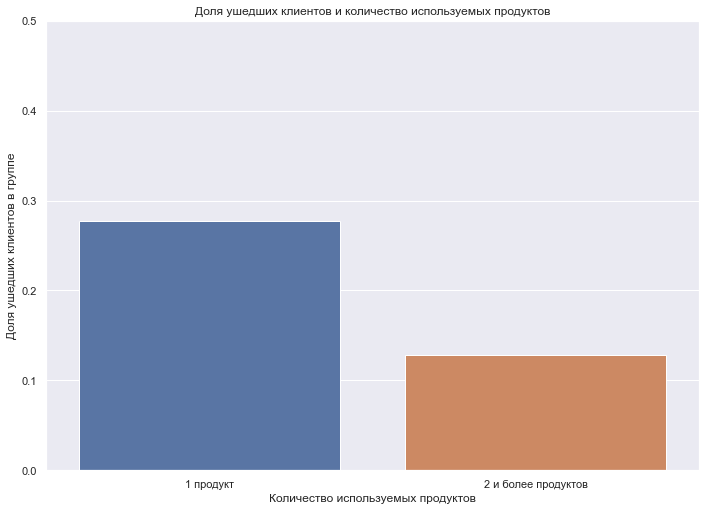

In [17]:
# создадим функцию для оформления столбчатой диаграммы

def create_barlot(df, category, ylim=1):
    ax = sns.barplot(data=df, x=category, y='Доля ушедших')
    plt.title('Доля ушедших клиентов и {}'.format(category.lower()))
    plt.xlabel(category)
    plt.ylabel('Доля ушедших клиентов в группе')
    ax.set_ylim([0, ylim])
    plt.show()
    
create_barlot(t, 'Количество используемых продуктов', 0.5)

***Вывод:***
- Появилась гипотеза: доля ушедших в группе клиентов, которые пользовались только одним продуктом, больше, чем в группе, где клиенты пользовались двумя и более продуктами.

Посмотрим распределение долей оттока 

In [18]:
t = churn_in_category(df, 'products', category_name='Количество используемых продуктов')
t

,Количество используемых продуктов,Доля ушедших,Количество клиентов в группе
0,1,0.28,5084
1,2,0.08,4590
2,3,0.83,266
3,4,1.00,60


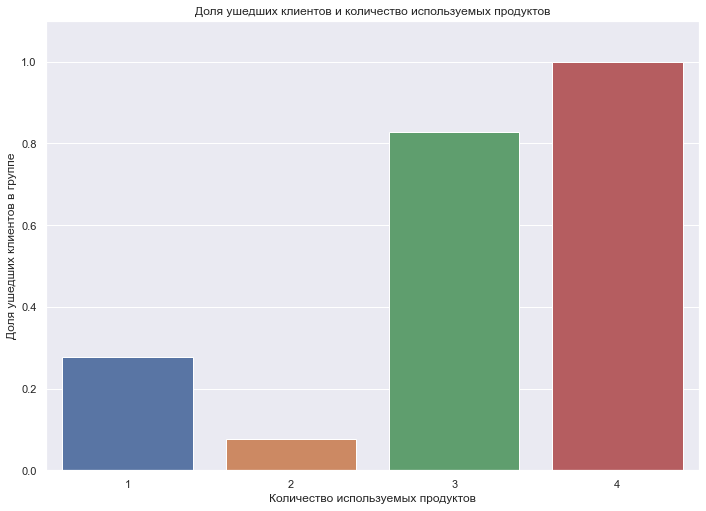

In [19]:
create_barlot(t, 'Количество используемых продуктов', 1.1)

- Так как в группе с 4 объектами количество клиентов слишком маленькое, нельзя считать ее репрезентативной и воспринимать 100% оттока, как достоверную информацию;
- Выборка клиентов с 3 объектами тоже не очень многочисленна. Но можно предположить, что у клиентов с 3 объектами доля оттока в несколько раз выше, чем у клиентов с одним объектом. Проверим эту гипотезу позже;
- Наименьшая доля оттока у клиентов с двумя объектами.

<a id='score_id'></a>

## Исследование наличия зависимости между кредитным рейтингом и оттоком

Построим график разброса двух переменных: кредитного рейтинга и оттока.

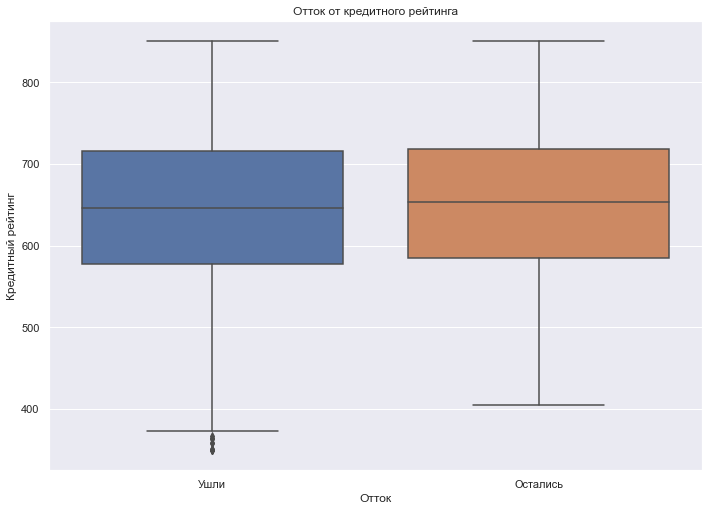

In [20]:
sns.boxplot(data=df, x="churn", y="score", order=[True, False])
plt.title('Отток от кредитного рейтинга')
plt.xlabel('Отток')
plt.ylabel('Кредитный рейтинг')
plt.xticks((0,1), ['Ушли', 'Остались'])
plt.show()

- Большинство клиентов имеют кредитный рейтинг от 500 до 800;
- Все клиенты с рейтингом ниже 400 ушели. Однако клиентов с таким низким рейтингов в целом не так много.

Попробуем назначить рейтингам следующие категории:
- низкий рейтинг - до 500;
- средний рейтинг - от 500 до 750;
- высокий рейтинг - от 750.

И посмотрим, меняется ли в зависимости от категории доля отточников.

In [21]:
# создадим функцию для определения категории по рейтингу
def score_category(x):
    if x >= 750:
        return 'Высокий рейтинг'
    elif x >= 500:
        return 'Средний рейтинг'
    else:
        return 'Низкий рейтинг'

# создадим столбец с категорией по рейтингу
df['category_by_score'] = df['score'].apply(score_category)

In [22]:
t = churn_in_category(df, 'category_by_score', category_name='Категория рейтинга')
t

,Категория рейтинга,Доля ушедших,Количество клиентов в группе
0,Высокий рейтинг,0.20,1623
1,Низкий рейтинг,0.24,632
2,Средний рейтинг,0.20,7745


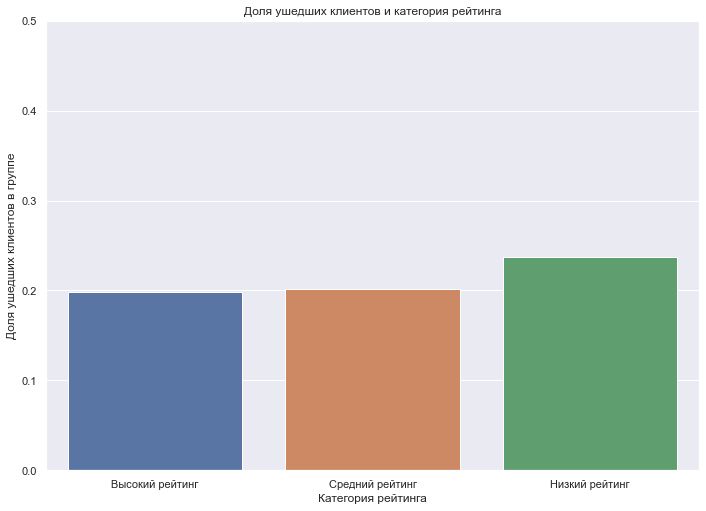

In [23]:
create_barlot(t.sort_values(by='Доля ушедших'), 'Категория рейтинга', 0.5)

***Выводы:***
- Клиенты распределены по категориям кредитного рейтинга неравномерно: меньше всех клиентов с низким рейтингом, наибольшее количество в группе со средним рейтингом;
- Однако даже самую малочисленную группу клиентов с низким рейтингом можно считать репрезентативной (632 клиента в группе);
- Значительной разницы в долях ушедших клиентов между группами, сформированными по кредитному рейтингу, не наблюдается.

<a id='city_id'></a>

## Исследование наличия зависимости между населенным пунктом и оттоком

Посмотрим на доли ушедших в каждом городе.

In [24]:
t = churn_in_category(df, 'city', category_name='Город')
t

,Город,Доля ушедших,Количество клиентов в группе
0,Ростов Великий,0.32,2509
1,Рыбинск,0.17,2477
2,Ярославль,0.16,5014


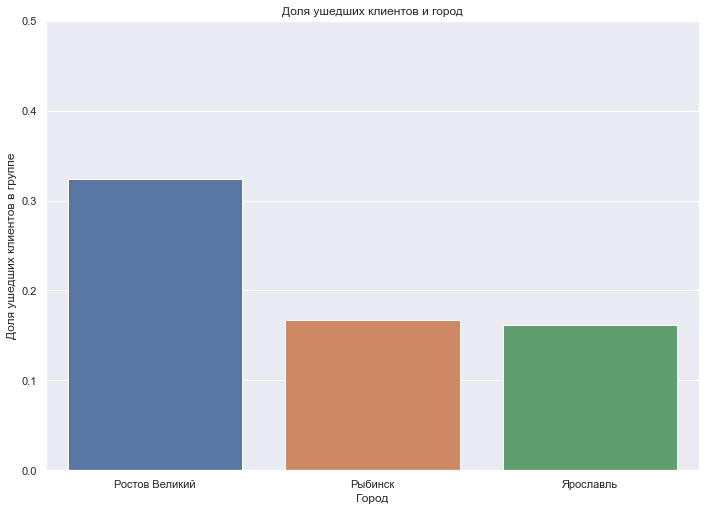

In [25]:
create_barlot(t, 'Город', 0.5)

***Выводы:***
- Количество клиентов в Рыбинске и в Ростове Великом примерно равное;
- В Ярославле клиентов примерно в 2 раза больше, чем в других двух городах;
- Доля оттока в Ярославле и Рыбинске 16-17%, а в Ростове Великом - в 2 раза больше. На это нужно обратить внимание.

<a id='age_id'></a>

## Исследование наличия зависимости между возрастом и оттоком

Сформируем группы по возрасту:
- до 29 лет;
- от 30 до 39 лет;
- от 40 до 49 лет;
- от 50 до 59 лет;
- от 60 лет.

In [26]:
# создадим функцию для определения категории по возрасту
def age_category(x):
    if x >= 60:
        return '60+ лет'
    elif x >= 50:
        return '50-59 лет'
    elif x >= 40:
        return '40-49 лет'
    elif x >= 30:
        return '30-39 лет'
    else:
        return '18-29 лет'

# создадим столбец с категорией по возрасту
df['category_by_age'] = df['age'].apply(age_category)

In [27]:
t = churn_in_category(df, 'category_by_age', category_name='Возраст')
t = t.sort_values(by='Доля ушедших')
t

,Возраст,Доля ушедших,Количество клиентов в группе
0,18-29 лет,0.08,1641
1,30-39 лет,0.11,4346
4,60+ лет,0.28,526
2,40-49 лет,0.31,2618
3,50-59 лет,0.56,869


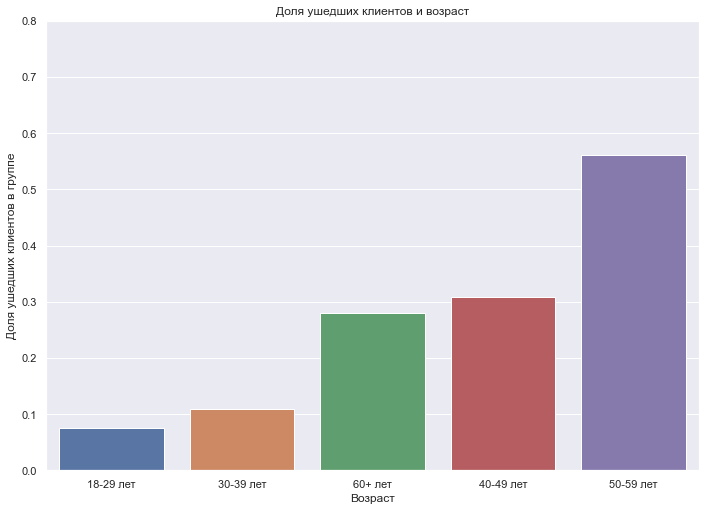

In [28]:
create_barlot(t, 'Возраст', 0.8)

***Выводы:***
- Самая многочисленная группа - 30-39 лет;
- Самая малочисленная группа - 60+ лет;
- В целом, можно предположить, что с возрастом риск оттока возрастает;
- Максимальная доля ушедших клиентов в группе 50-59 лет - наибольший риск оттока; 
- Клиенты в возрасте 60+ имеют средний риск оттока - на уровне клиентов 40-49 лет.

<a id='objects_id'></a>

## Исследование наличия зависимости между количеством объектов и оттоком

Количество объектов по пользователям распределено почти равномерно между значениями 1-9 объектов. Выпадают только группы совсем без объектов и с 10 объектами.

Посмотрим долю оттока в каждой группе.

In [29]:
t = churn_in_category(df, 'objects', category_name='Количество объектов')
t

,Количество объектов,Доля ушедших,Количество клиентов в группе
0,0,0.23,413
1,1,0.22,1035
2,2,0.19,1048
3,3,0.21,1009
4,4,0.21,989
5,5,0.21,1012
6,6,0.20,967
7,7,0.17,1028
8,8,0.19,1025
9,9,0.22,984


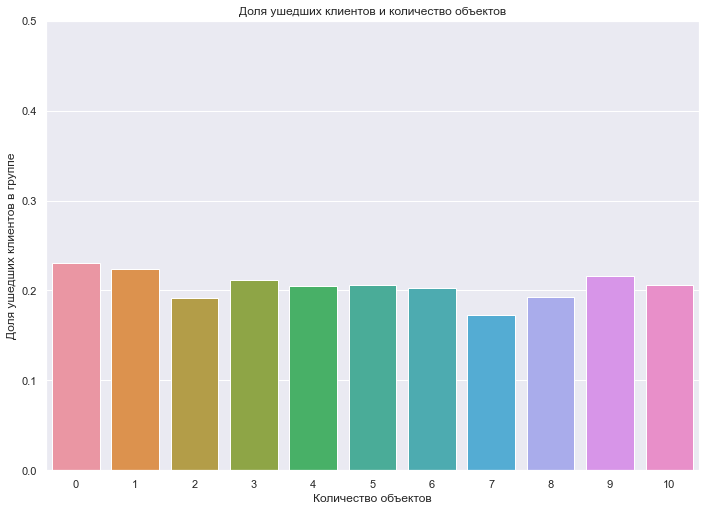

In [30]:
create_barlot(t, 'Количество объектов', 0.5)

***Выводы:***
- Несмотря на то, что группы с 0 и с 10 объектами, самые малочисленные, они все же остаются репрезентативными (413 и 490 записей, соответственно);
- Значительной разницы в доле оттока между группами с разным количеством объектов нет - в среднем отток в каждой группе можно считать равным 20%.

<a id='salary_id'></a>

## Исследование наличия зависимости между зарплатой и оттоком

Зарплата пользователей распределена примерно равномерно. Поэтому попробуем разделить их по зарплате на 4 группы по квартилям. 

In [31]:
df['category_by_salary'] = pd.qcut(df['estimated_salary'], 4)

In [32]:
t = churn_in_category(df, 'category_by_salary', category_name='Уровень зарплаты')
t

,Уровень зарплаты,Доля ушедших,Количество клиентов в группе
0,"(11.579, 51002.11]",0.20,2500
1,"(51002.11, 100193.915]",0.20,2500
2,"(100193.915, 149388.248]",0.20,2500
3,"(149388.248, 199992.48]",0.22,2500


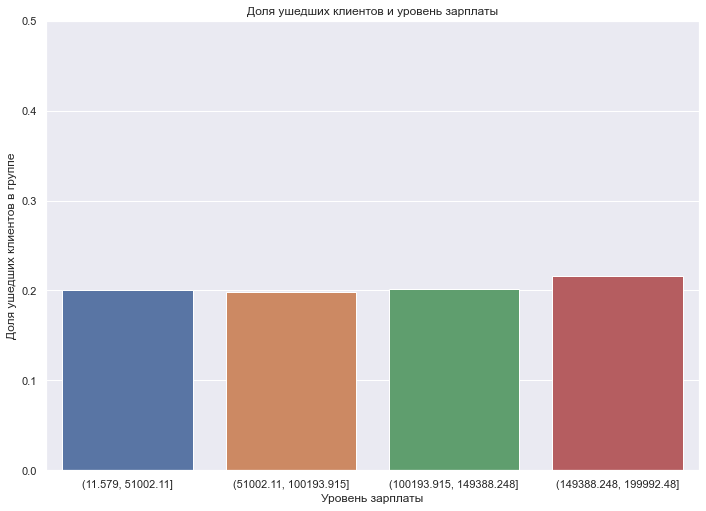

In [33]:
create_barlot(t, 'Уровень зарплаты', 0.5)

***Выводы:***
- Отток во всех группах, кроме группы с самыми высокими зарплатами, равен 20%;
- В группе с самыми высокими зарплатами отток чуть выше - 22%.

<a id='balance_id'></a>

## Исследование наличия зависимости между балансом на счёте и оттоком

Баланс был не указан примерно у трети всех пользователей. Тех пользователей, у которых он указан, попробуем разделить на 4 группы по квартилям. 

In [34]:
df['category_by_balance'] = pd.qcut(df['balance'], 4)

In [35]:
t = churn_in_category(df, 'category_by_balance', 'Баланс на счете')
t

,Баланс на счете,Доля ушедших,Количество клиентов в группе
0,"(3768.689, 100181.975]",0.21,1596
1,"(100181.975, 119839.69]",0.27,1596
2,"(119839.69, 139512.29]",0.25,1595
3,"(139512.29, 250898.09]",0.23,1596


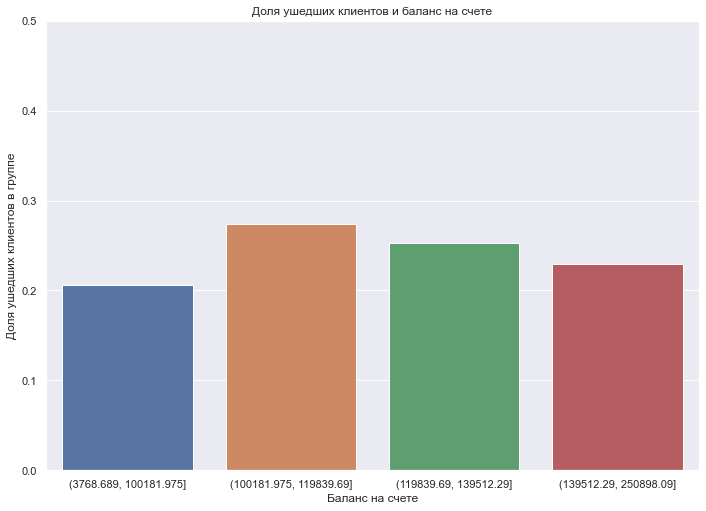

In [36]:
create_barlot(t, 'Баланс на счете', 0.5)

***Выводы:***
- Прямой или обратной зависимости оттока от уровня баланса на счете не наблюдается;
- Наибольшая доля оттока наблюдается в группе клиентов с балансом от 101,2 тысяч до 119,8 тысяч - 27%;
- Наименьший отток в группе с наименьшим балансом: от 3,8 тысяч до 101,2 тысяч - 21%;
- В целом, можно предположить, что пользователи с наибольшими и наименьшими балансами на счетах уходят реже, чем пользователи, имеющие средний уровень баланса.

<a id='credit_card_id'></a>

## Исследование зависимости между наличием кредитной карты и оттоком

Сравним доли оттока в двух группах: у пользователей с кредитной картой и без нее. 

In [37]:
t = churn_in_category(df, 'credit_card', 'Наличие кредитной карты')
t['Наличие кредитной карты'] = t['Наличие кредитной карты'].apply(lambda x: 'Есть карта' if x == True else 'Нет карты')

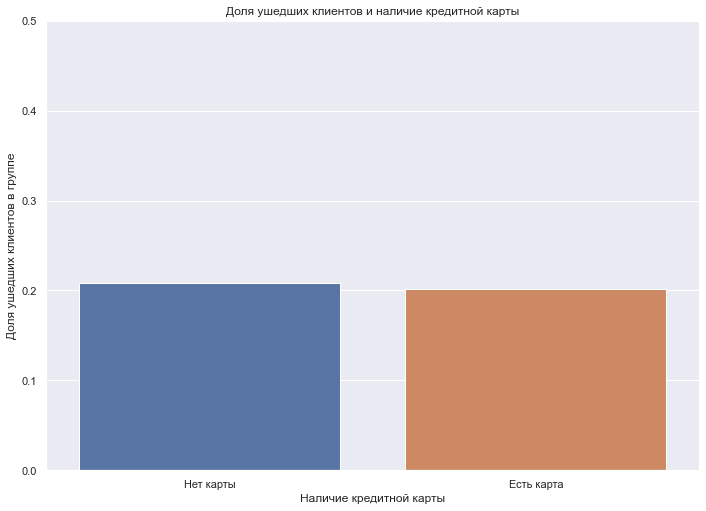

In [38]:
create_barlot(t, 'Наличие кредитной карты', 0.5)

***Выводы:***
- Количество пользователей с кредитной картой более, чем в 2 раза, превышает количество пользователей без нее. Тем не менее, исходя из количества пользователей в каждой группе, обе можем считать репрезентативными;
- Наличие кредитной карты не влияет на отток - доля ушедших клиентов в обеих группах примерно одинаковая. 

### Параметры, характерные для клиента сегмента оттока:
- Количество продуктов, которыми пользуется клиент, оказывает сильное влияние на отток:
	- когда клиент пользуется только одним продуктом риск его потерять выше, чем когда он пользуется двумя и более;
	- наибольшая доля оттока у пользователей с 3 продуктами. Но эту гипотезу мы еще проверим.
- Если у клиента кредитный рейтинг ниже 400, велика вероятность, что он окажется в оттоке;
- Доля "отточников" в Ростове Великом в 2 раза выше, чем в Ярославле и в Рыбинске. Менеджменту, вероятно, стоит обратить на это внимание;
- После 40 лет риск оттока возрастает в 2 раза. Наибольший риск оттока у возрастной группы 50-59 лет;
- Количество объектов, наличие кредитной карты и зарплата не оказывают существенного влияния на отток;
- Пользователь с максимальным или минимальным балансом на счете менее подвержен риску ухода, чем клиент со средним балансом.

<a id='segmentation_id'></a>

## Сегментация пользователей по количеству продуктов

Отдельно остановимся на сегментации клиентов по количеству используемых ими продуктов.

Основная масса клиентов, информация о которых представлена в наших данных, пользуется одним, двумя или тремя продуктами.

Четырьмя продуктами пользуются только 60 клиентов, что репрезентативным считать нельзя.

Тремя продуктами пользуется 266 клиентов из 10000, что тоже сложно назвать репрезентативным.

Поэтому сконцентрируемся на двух сегментах: клиенты, пользующиеся одним продуктом, и клиенты, пользующиеся двумя продуктами.

In [39]:
df_segments = df[-df['products'].isin([3,4])].copy()

### Кредитный рейтинг внутри сегментов

Посмотрим, как клиенты распределяются по обозначенным нами категориям кредитного рейтинга внутри сегментов.  

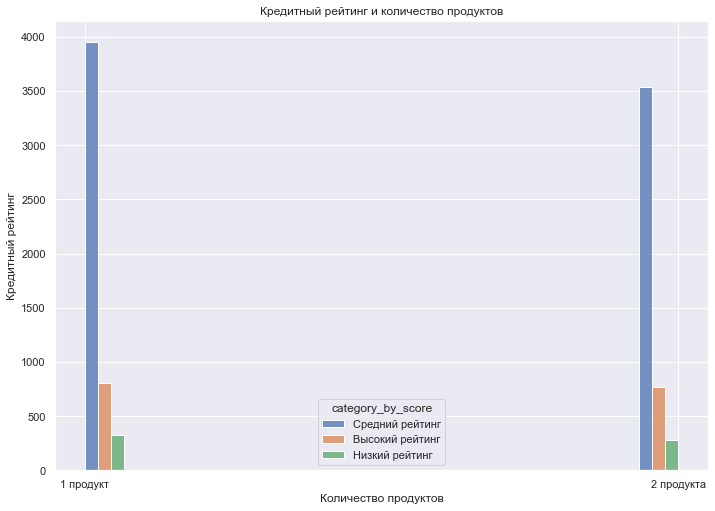

In [40]:
def create_hist(data, category, category_name='Название категории'):
    ax = sns.histplot(data=data, x="products", hue=category, multiple="dodge")
    plt.title('{} и количество продуктов'.format(category_name))
    plt.xlabel('Количество продуктов')
    plt.ylabel(category_name)
    plt.xticks((1,2), ['1 продукт', '2 продукта'])
    plt.show()

create_hist(df_segments, 'category_by_score', 'Кредитный рейтинг') 

- Заметной разницы между сегментами не наблюдается;
- Наибольшее количество клиентов в обоих сегментах имеет средний кредитный рейтинг;
- Наименьшее количество клиентов - низкий рейтинг.

### Возраст внутри сегментов

Посмотрим, как клиенты распределяются по полу внутри сегментов.  

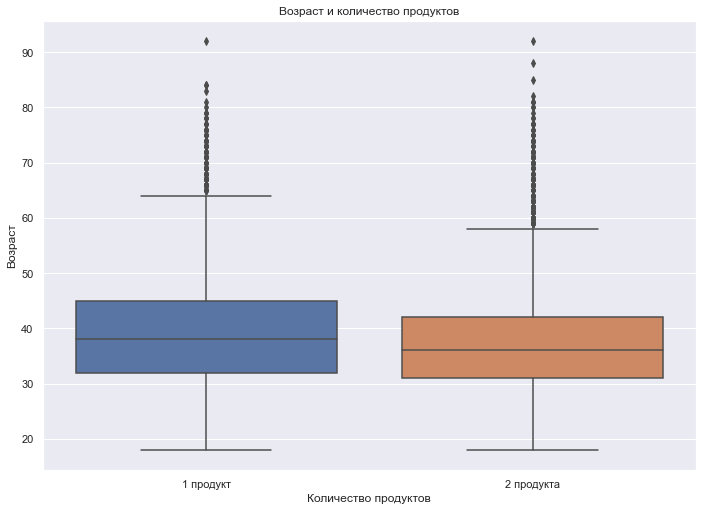

In [41]:
sns.boxplot(data=df_segments, x="products", y="age")
plt.title('Возраст и количество продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Возраст')
plt.xticks((0,1), ['1 продукт', '2 продукта'])
plt.show()

- Средний возраст клиентов, пользовавшихся одним продуктом, на 3-5 лет выше, чем у клиентов, пользовавшихся двумя продуктами.

### Города внутри сегментов

Посмотрим, как клиенты распределяются по городам внутри сегментов.  

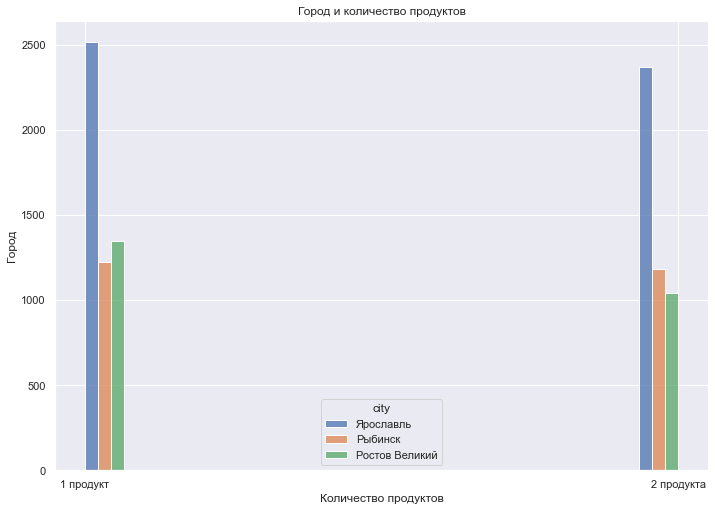

In [42]:
create_hist(df_segments, 'city', 'Город') 

- Наибольшее количество клиентов в обоих сегментах - из Ярославля;
- Количество клиентов примерно равно распределено между Рыбинском и Ростовом Великим в обоих сегментах;
- Однако можно отметить, что в Ростове клиентов использующих один продукт немного больше, чем использующих два продукта.

### Распределение по полу внутри сегментов

Посмотрим, как клиенты распределяются по полу внутри сегментов.  

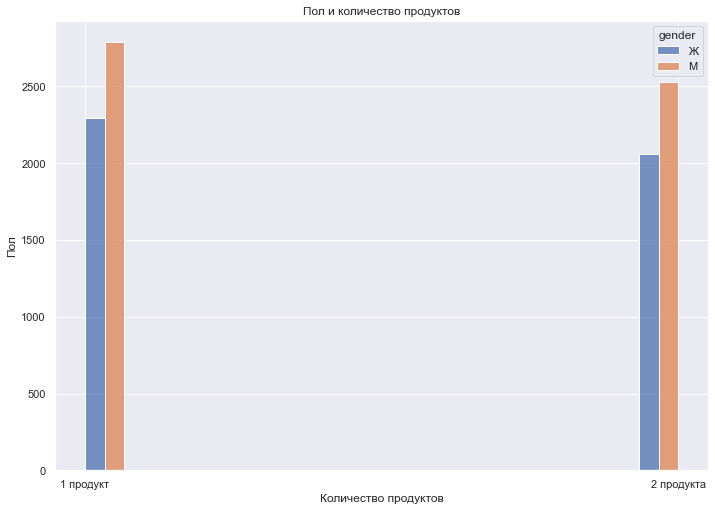

In [43]:
create_hist(df_segments, 'gender', 'Пол') 

- В обоих сегментах отношение количества мужчин к женщинам можно считать одинаковым.

### Уровень баланса внутри сегментов

Посмотрим, как клиенты распределяются по уровню баланса внутри сегментов.  

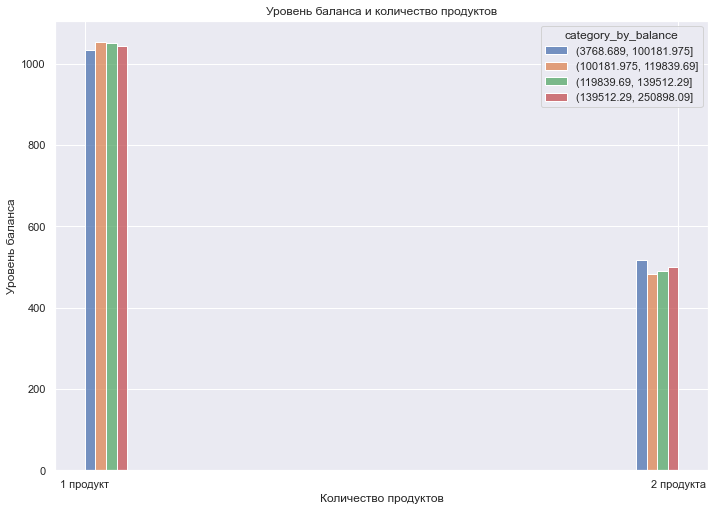

In [44]:
create_hist(df_segments, 'category_by_balance', 'Уровень баланса') 

- В сегменте одного продукта преобладают клиенты со средним (от 100,2 до 119,8 тысяч) и выше среднего балансами (от 119,8 до 139,5 тысяч), а в сегменте двух продуктов - с низкими (от 3,8 до 100,2 тысяч) и высокими балансами (от 139,5 тысяч).

### Уровень доходов внутри сегментов

Посмотрим, как клиенты распределяются по уровню зарплат внутри сегментов.  

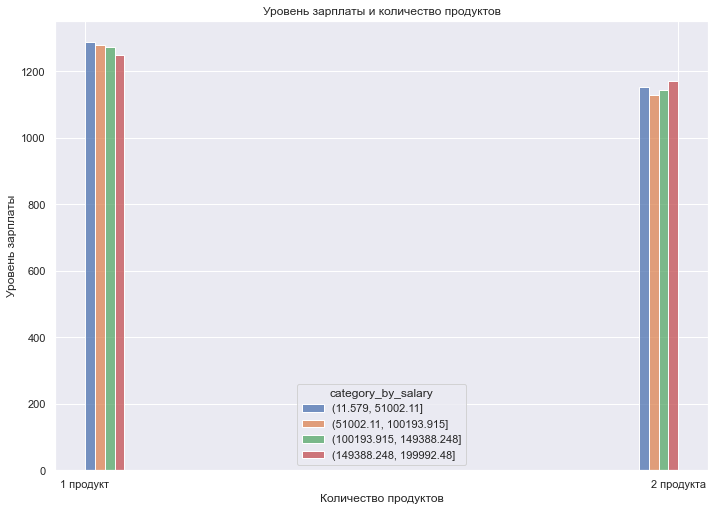

In [45]:
create_hist(df_segments, 'category_by_salary', 'Уровень зарплаты') 

- В сегменте одного продукта преобладают клиенты со низким (от 11,6) и средним уровнем дохода (от 51 до 100,2 тысяч), а в сегменте двух продуктов - с низким (от 11,6 тысяч) и высоким уровнем дохода (от 149,3 тысяч).

### Количество объектов внутри сегментов

Посмотрим, как клиенты распределяются по количеству объектов внутри сегментов.  

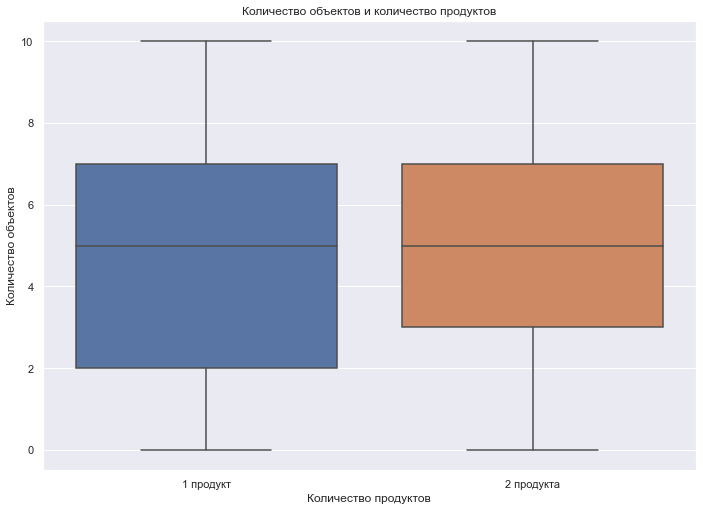

In [46]:
sns.boxplot(data=df_segments, x="products", y="objects")
plt.title('Количество объектов и количество продуктов')
plt.xlabel('Количество продуктов')
plt.ylabel('Количество объектов')
plt.xticks((0,1), ['1 продукт', '2 продукта'])
plt.show()

- В среднем количество объектов у клиентов в обоих сегментах равно 5.

### Количество клиентов с кредитной картой внутри сегментов

Посмотрим, как клиенты распределяются по наличию кредитной карты внутри сегментов.  

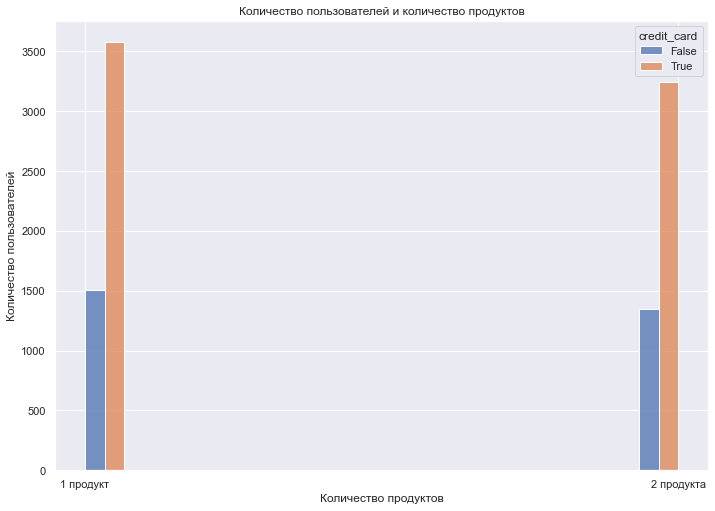

In [47]:
create_hist(df_segments, 'credit_card', 'Количество пользователей') 

- Между наличием кредитной карты и количеством используемых продуктов взаимосвязи не наблюдается.

### Количество активных клиентов внутри сегментов

Посмотрим, как активные клиенты внутри сегментов.

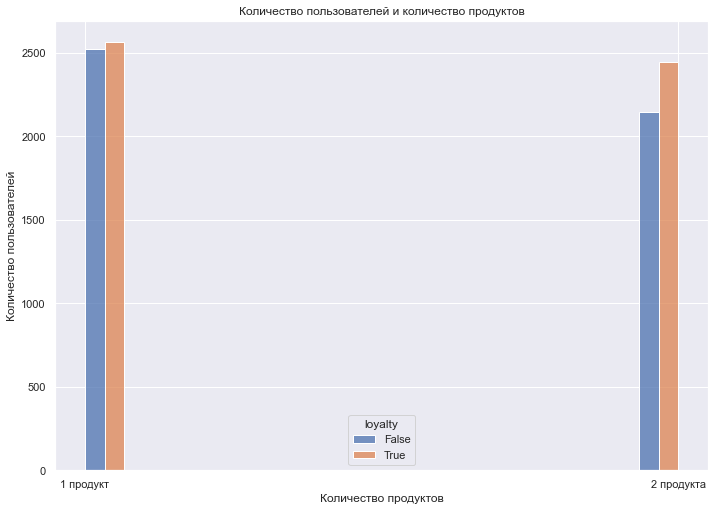

In [48]:
create_hist(df_segments, 'loyalty', 'Количество пользователей') 

- В сегменте с одним продуктом доли активных и неактивных клиентов примерно равные, а в сегменте с двумя продуктами количество активных клиентов больше.

### Доли ушедших клиентов внутри сегментов

Посмотрим, как распределяются ушедшие и оставшиеся клиенты внутри сегментов.  

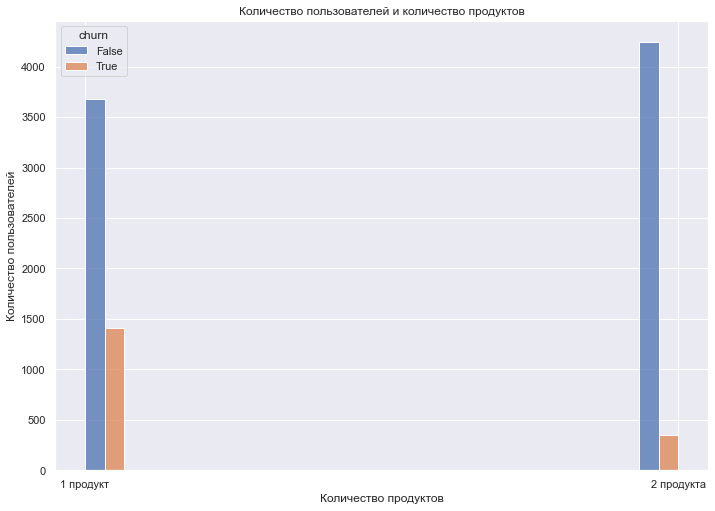

In [49]:
create_hist(df_segments, 'churn', 'Количество пользователей') 

- Доля ушедших клиентов в сегменте с одним продуктом в разы превышает долю аналогичных клиентов в сегменте с двумя продуктами.

***Итоги сегментации пользователей по количеству используемых продуктов:***
1. Пользователи, использующие один продукт:
    - Средний возраст на 3-5 лет выше, чем у клиентов, пользовавшихся двумя продуктами;
    - Преобладают клиенты со средним (от 100,2 до 119,8 тысяч) и выше среднего балансами (от 119,8 до 139,5 тысяч); 
    - Преобладают клиенты со низким (от 11,6) и средним уровнем дохода (от 51 до 100,2 тысяч);
    - Доли активных и неактивных клиентов примерно равные;
    - Доля ушедших клиентов в разы превышает долю ушедших в сегменте с двумя продуктами.


2. Пользователи, использующие два продукта:
    - Средний возраст на 3-5 лет ниже, чем у клиентов, пользовавшихся одним продуктом;
    - Преобладают клиенты с низкими (от 3,8 до 100,2 тысяч) и высокими балансами (от 139,5 тысяч);
    - Преобладают клиенты с низким (от 11,6 тысяч) и высоким уровнем дохода (от 149,3 тысяч);
    - Количество активных пользователей больше неактивных;
    - Доля ушедших клиентов в разы ниже доли ушедших клиентов в сегменте с одним продуктом.


3. Общее:
    - Наибольшее количество клиентов в обоих сегментах имеет средний кредитный рейтинг;
    - Наибольшее количество клиентов в обоих сегментах - из Ярославля;
    - В обоих сегментах мужчин больше, чем женщин;
    - В среднем количество объектов у клиентов в обоих сегментах равно 5;
    - Между наличием кредитной карты и количеством используемых продуктов взаимосвязи не наблюдается.

## Потенциальные способы сегментации пользователей

Посмотрим на попарные графики зависимости параметров, представленных в нашем датасете. 

Для дальнейшей проверки корреляции бинарно закодируем категориальные перемеменные: `city` и `gender`. 

In [50]:
# создадим функцию для бинарного кодирования
def encode(data, column):
    for col in data[column].unique():
        data[col] = (data[column] == col).astype(int)
    return data

df = encode(df, 'city')
df = encode(df, 'gender')

- Выделения явных групп и зависимостей не наблюдается. 

На всякий случай проверим еще корреляцию. Но скорее всего, при таких графиках получим коэффициенты близкие к нулю.

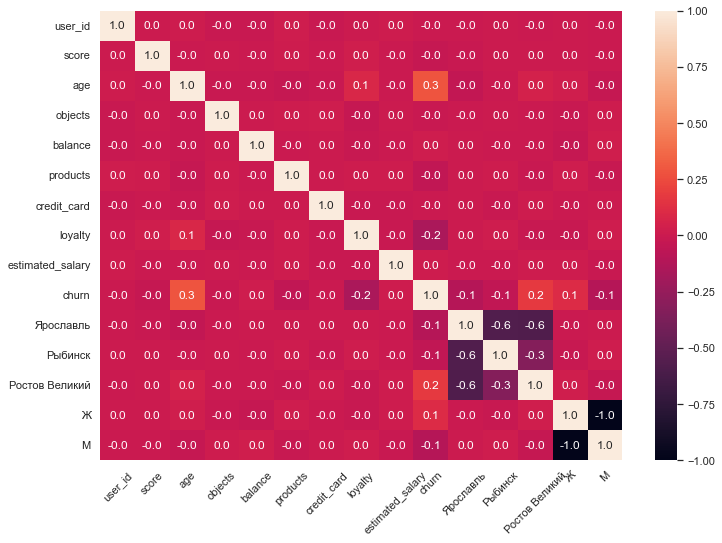

In [51]:
sns.heatmap(df.corr(), annot=True, fmt=".1f")
plt.xticks(rotation=45)
plt.show()


- Ожидаемо, попарные коэффициент корреляции предоставленных нам параметров оказались близки к нулю - линейных зависимостей нет.
- Большие отрицательные коффициенты между закодированными категорийными данными тоже вполне естестевенны - если клиент из Ярославля, он не может быть из Рыбинска и т.д. при условии, что с данными все в порядке. А у нас именно так. 

Поэтому, основываясь на исследовательском анализе наших данных, для **сегментации клиентов банка** можно использовать следующие группы:
- по кредитному рейтингу: "низкий" (до 500), "средний" (500-750) и "высокий" (больше 750). Но на прогнозирование оттока эта сегментация, скорее всего, не повлияет;
- по возрасту: "до 40 лет", "40-50 лет" и "50+ лет";
- по городу: "Ярославль", "Ростов Великий" и "Рыбинск". Если клиент из Ростова, то риск его ухода, по данным на момент анализа, максимальный среди трёх городов;
- по количеству используемых продуктов: "использует один продукт" или "использует два и более продуктов". С увеличением количества используемых продуктов с одного до двух, вероятность ухода снижается. Однако надо исправить ситуацию с лояльностью клиентов, использующих три продукта;
-  по наличию кредитной карты: "есть" или "нет". Предположительно, этот параметр не влияет на отток;
-  по уровню баланса: "низкий" (до 100 тысяч), "средний" (от 100 до 120 тысяч), "выше среднего" (от 120 до 140 тысяч) и "максимальный" (от 140 тысяч). Причём клиенты со средним балансом, как мы предполагаем, имеют большую вероятность ухода по сравнению с пользователями с низкими и максимальными  уровнями баланса;
- по уровню зарплат: "низкий" (до 51 тысячи), "средний" (от 51 до 100 тысяч), "выше среднего" (от 100 до 149 тысяч) и "максимальный" (больше 149 тысяч). Однако этот параметр не оказывает влияния на отток;
-  по количеству объектов: не наблюдается рациональных  причин объединять клиентов в группы по каким-либо диапазонам. Поэтому для каждого количества объектов может быть определена отдельная группа. В любом случае, как мы установили, этот параметр не оказывает влияния на отток.

<a id='stat_tests_id'></a>

## Проверка гипотез

### Гипотеза о равенстве среднего дохода клиентов, пользующихся одним продуктом и двумя продуктами

**Нулевая гипотеза:** Средний доход клиентов, пользующихся одним продуктом, и средний доход клиентов, пользующихся двумя продуктами, равны.

**Альтернативная гипотеза:** Средний доход клиентов, пользующихся одним продуктом, и средний доход клиентов, пользующихся двумя продуктами, не равны.

**Уровень значимости** α=0,05.

Подготовим две выборки зарплат: для клиентов с одним продуктом и для клиентов с двумя продуктами.

In [52]:
one_product = df[df['products']==1]['estimated_salary']
two_products = df[df['products']==2]['estimated_salary']

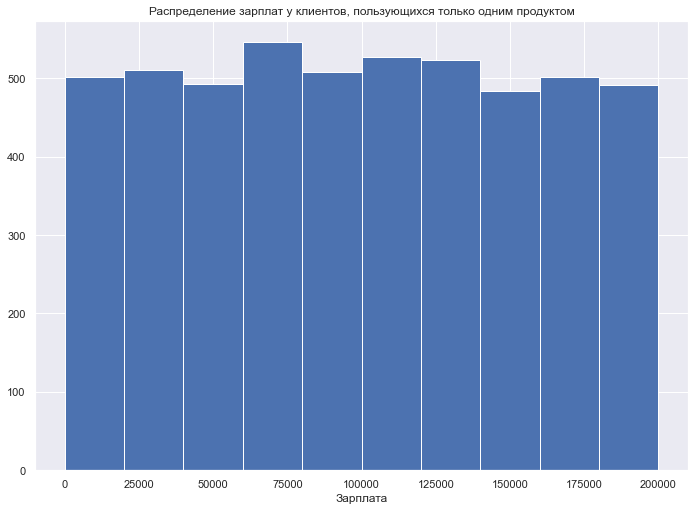

In [53]:
one_product.hist()
plt.title('Распределение зарплат у клиентов, пользующихся только одним продуктом')
plt.xlabel('Зарплата')
plt.show()

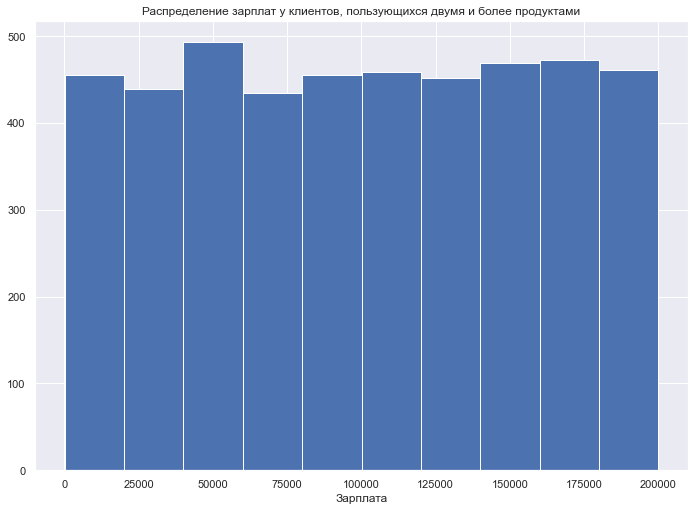

In [54]:
two_products.hist()
plt.title('Распределение зарплат у клиентов, пользующихся двумя и более продуктами')
plt.xlabel('Зарплата')
plt.show()

Выборки зарплат наших клиентов распределены, скорее, равномерно, чем нормально. 

Однако для применения статистических тестов, основанных на нормальном распределении, нам необходимо, чтобы не сама выборка была распределена нормально, а выборочное среднее было распределено нормально вокруг среднего генеральной совокупности. 

Согласно центральной предельной теореме, при достаточно большом количестве наблюдений в выборке выборочное среднее распределяется нормально вне зависимости от распределения генеральной совокупности.

Следовательно, в нашем случае статистические тесты применимы.

In [55]:
results = st.ttest_ind(one_product, two_products, equal_var=False)

print('p-value = {}'.format(results.pvalue))

print('Средняя зарплата клиентов, пользующихся одним продуктом: {}'.format(one_product.mean()))
print('Средняя зарплата клиентов, пользующихся двумя продуктами: {}'.format(two_products.mean()))

p-value = 0.4106493940071987
Средняя зарплата клиентов, пользующихся одним продуктом: 99487.25685090493
Средняя зарплата клиентов, пользующихся двумя продуктами: 100452.01282135084


***Выводы:***
- Средняя зарплата клиентов, пользующихся двумя продуктами, больше, чем у клиентов, пользующихся одним продуктом, почти на 1000;
- Полученное p-value значительно превышает заданный нами уровень значимости α, что не позволяет отвергнуть нулевую гипотезу о равенстве средних зарплат;
- Наблюдаемая разница в зарплатах не является статистически значимой.

### Гипотеза о равенстве средних балансов на счетах у двух групп пользователей: с кредитной картой и без неё

**Нулевая гипотеза:** Средний баланс клиентов с кредитной картой равен среднему балансу клиентов без кредитной карты.

**Альтернативная гипотеза:** Средний баланс клиентов с кредитной картой не равен среднему балансу клиентов без кредитной карты.

**Уровень значимости** α=0,05.

Подготовим две выборки балансов: для клиентов с кредитной картой и без нее. 

Помним, что в столбце баланса у нас было довольно много пропусков, которые необходимо удалить из наших выборок перед тестом.

In [56]:
have_card = df[df['credit_card']==True]['balance'].dropna()
no_card = df[df['credit_card']==False]['balance'].dropna()

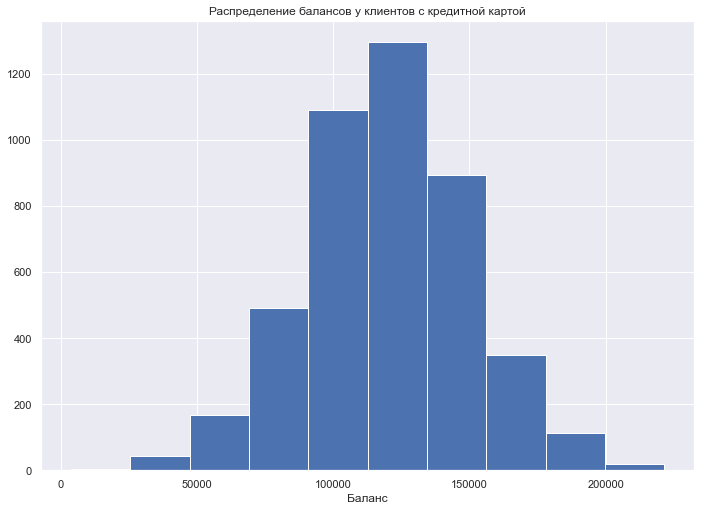

In [57]:
have_card.hist()
plt.title('Распределение балансов у клиентов с кредитной картой')
plt.xlabel('Баланс')
plt.show()

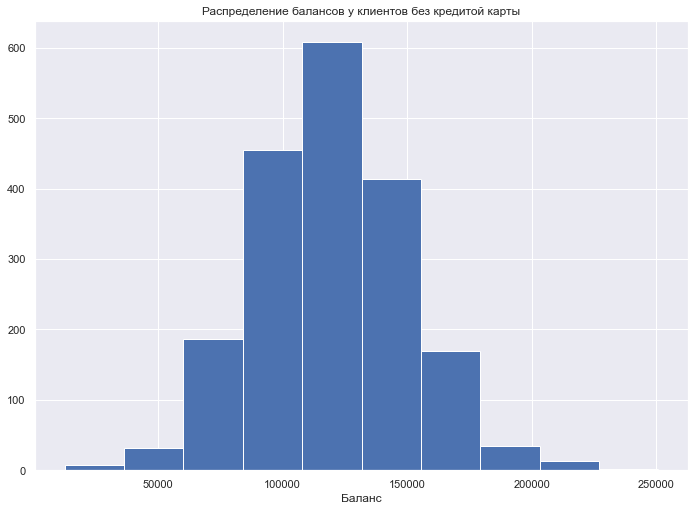

In [58]:
no_card.hist()
plt.title('Распределение балансов у клиентов без кредитой карты')
plt.xlabel('Баланс')
plt.show()

Рассчитаем статистический тест.

In [59]:
results = st.ttest_ind(have_card, no_card, equal_var=True)

print('p-value = {}'.format(results.pvalue))

print('Средний баланс клиентов, имеющих кредитную карту: {}'.format(have_card.mean()))
print('Средний баланс клиентов, не имеющих кредитной карты: {}'.format(no_card.mean()))

p-value = 0.5913488228962429
Средний баланс клиентов, имеющих кредитную карту: 119960.15539771461
Средний баланс клиентов, не имеющих кредитной карты: 119519.12465625013


***Выводы:***
- Средние балансы клиентов приблизительно равны;
- Полученное p-value значительно превышает заданный нами уровень значимости α, что не позволяет отвергнуть нулевую гипотезу о равенстве средних балансов.

<a id='tut1_id'></a>

### Гипотеза о равенстве долей ушедших клиентов, пользовавшихся только одним продуктом, и клиентов, пользовавшихся двумя и более продуктами

**Нулевая гипотеза:** Доля ушедших клиентов, пользовавшихся одним продуктом, и доля клиентов, пользовавшихся двумя и более продуктами, равны.

**Альтернативная гипотеза:** Доля ушедших клиентов, пользовавшихся одним продуктом, и доля клиентов, пользовавшихся двумя и более продуктами, не равны.

**Уровень значимости** α=0,05.

In [60]:
t = churn_in_category(df, 'category_by_product', category_name='Количество используемых продуктов')
t

,Количество используемых продуктов,Доля ушедших,Количество клиентов в группе
0,1 продукт,0.28,5084
1,2 и более продуктов,0.13,4916


In [61]:
# доля ушедших в первой группе:
p1 = t.loc[0, 'Доля ушедших']

# количество ушедших в первой группе:
left1 = p1 * t.loc[0, 'Количество клиентов в группе']

# доля ушедших во второй группе:
p2 = t.loc[1, 'Доля ушедших']

# количество ушедших во второй группе:
left2 = p2 * t.loc[1, 'Количество клиентов в группе']

# доля ушедших в комбинированном датасете:
p_combined = (left1 + left2) / (t.loc[0, 'Количество клиентов в группе'] + t.loc[1, 'Количество клиентов в группе'])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/t.loc[0, 'Количество клиентов в группе'] + 1/t.loc[1, 'Количество клиентов в группе']))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value =', p_value)

p-value = 0.0


***Выводы:***
- Полученное p-value позволяет отвергнуть нулевую гипотезу;
- Разница между долями оттока клиентов, пользовавшихся одним продуктом, и клиентов, пользовавшимися двумя и более продуктами, является статистически значимой.  

<a id='tut2_id'></a>

### Гипотеза о равенстве долей ушедших клиентов, пользовавшихся только одним продуктом, и клиентов, пользовавшихся тремя продуктами

**Нулевая гипотеза:** Доля ушедших клиентов, пользовавшихся одним продуктом, и доля клиентов, пользовавшихся тремя продуктами, равны.

**Альтернативная гипотеза:** Доля ушедших клиентов, пользовавшихся одним продуктом, и доля клиентов, пользовавшихся тремя продуктами, не равны.

**Уровень значимости** α=0,05.

In [62]:
t = churn_in_category(df, 'products', category_name='Количество используемых продуктов')
t

,Количество используемых продуктов,Доля ушедших,Количество клиентов в группе
0,1,0.28,5084
1,2,0.08,4590
2,3,0.83,266
3,4,1.00,60


In [63]:
# доля ушедших в первой группе:
p1 = t.loc[0, 'Доля ушедших']

# количество ушедших в первой группе:
left1 = p1 * t.loc[0, 'Количество клиентов в группе']

# доля ушедших во второй группе:
p2 = t.loc[2, 'Доля ушедших']

# количество ушедших во второй группе:
left2 = p2 * t.loc[2, 'Количество клиентов в группе']

# доля ушедших в комбинированном датасете:
p_combined = (left1 + left2) / (t.loc[0, 'Количество клиентов в группе'] + t.loc[2, 'Количество клиентов в группе'])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/t.loc[0, 'Количество клиентов в группе'] + 1/t.loc[2, 'Количество клиентов в группе']))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value =', p_value)

p-value = 0.0


***Выводы:***
- Полученное p-value позволяет отвергнуть нулевую гипотезу;
- Разница между долями оттока клиентов, пользовавшихся одним продуктом, и клиентов, пользовавшимися тремя продуктами, является статистически значимой. Следовательно, сегментом с наибольшей долей оттока можно считать клиентов с тремя продуктами.

<a id='summary_id'></a>

## Выводы по проекту


***Общие сведения о клиентах:***
- Разброс кредитного рейтинга: от 350 до 850. Половина пользователей - с рейтингом выше 652;
- Возраст: от 18 до 92. Половина пользователей - старше 37;
- Пользователи распределены равномерно по количеству объектов от 1 до 9. Значительно меньше пользователей в группах без объектов и с 10 объектами;
- Разброс баланса на счете: от 3,8 тысяч до 250,9 тысяч. Половина пользователей, у которых указан баланс, - с балансом больше 119,8 тысяч;
- Половина пользователей пользуется только 1 продуктом;
- Половина пользователей имеет зарплату больше 100 тысяч.
- Кредитная карточка есть у 71% клиентов;
- Активных и неактивных пользователей примерно равное количество в нашей выборке (52% и 48%, соответственно);
- Ушедших клиентов - 20%;
- Количество клиентов в Рыбинске и в Ростове Великом примерно равное;
- В Ярославле клиентов примерно в 2 раза больше, чем в других двух городах.

***Итоги сегментации пользователей по количеству используемых продуктов:***
1. Пользователи, использующие один продукт:
    - Средний возраст на 3-5 лет выше, чем у клиентов, пользовавшихся двумя продуктами;
    - Преобладают клиенты со средним (от 100,2 до 119,8 тысяч) и выше среднего балансами (от 119,8 до 139,5 тысяч); 
    - Преобладают клиенты со низким (от 11,6) и средним уровнем дохода (от 51 до 100,2 тысяч);
    - Доли активных и неактивных клиентов примерно равные;
    - Доля ушедших клиентов в разы превышает долю ушедших в сегменте с двумя продуктами.


2. Пользователи, использующие два продукта:
    - Средний возраст на 3-5 лет ниже, чем у клиентов, пользовавшихся одним продуктом;
    - Преобладают клиенты с низкими (от 3,8 до 100,2 тысяч) и высокими балансами (от 139,5 тысяч);
    - Преобладают клиенты с низким (от 11,6 тысяч) и высоким уровнем дохода (от 149,3 тысяч);
    - Количество активных пользователей больше неактивных;
    - Доля ушедших клиентов в разы ниже доли ушедших клиентов в сегменте с одним продуктом.


3. Общее:
    - Наибольшее количество клиентов в обоих сегментах имеет средний кредитный рейтинг;
    - Наибольшее количество клиентов в обоих сегментах - из Ярославля;
    - В обоих сегментах мужчин больше, чем женщин;
    - В среднем количество объектов у клиентов в обоих сегментах равно 5;
    - Между наличием кредитной карты и количеством используемых продуктов взаимосвязи не наблюдается.
    
***Анализ оттока:***
- Значительной разницы в долях ушедших клиентов между группами, сформированными по кредитному рейтингу, не наблюдается;
- Доля оттока в Ярославле и Рыбинске 16-17%, а в Ростове Великом - 32%;
- На основе наших данных можно предположить, что с возрастом риск оттока возрастает. Максимальная доля ушедших клиентов в группе 50-59 лет;
- Значительной разницы в доле оттока между группами клиентов с разным количеством объектов нет - в среднем отток в каждой группе можно считать равным 20%;
- Почти при любом уровне зарплаты доля оттока - 20%. В группе с самыми высокими зарплатами отток чуть выше - 22%;
- Прямой или обратной зависимости оттока от уровня баланса на счете не наблюдается. Но в целом, наши данные говорят, что пользователи с наибольшими и наименьшими балансами на счетах уходят реже, чем пользователи, имеющие средний уровень баланса;
- Наличие кредитной карты не влияет на долю оттока;
- Доля оттока клиентов, пользовавшихся одним продуктом, в два раза больше доли оттока клиентов, пользовавшимися двумя и более продуктами. И эти разницы являются статистически значимыми.

***Портрет клиента сегмента оттока:***
- Количество продуктов, которыми пользуется клиент, оказывает сильное влияние на отток:
	- когда клиент пользуется только одним продуктом риск его потерять выше, чем когда он пользуется двумя и более;
	- наибольшая доля оттока у пользователей с 3 продуктами;
- Если у клиента кредитный рейтинг ниже 400, велика вероятность, что он окажется в оттоке;
- Доля "отточников" в Ростове Великом в 2 раза выше, чем в Ярославле и в Рыбинске;
- После 40 лет риск оттока возрастает в 2 раза. Наибольший риск оттока у возрастной группы 50-59 лет;
- Количество объектов, наличие кредитной карты и зарплата не оказывают существенного влияния на отток;
- Пользователь с максимальным или минимальным балансом на счете менее подвержен риску ухода, чем клиент со средним балансом.

***Проверка гипотез:***
- Разница в средних зарплатах клиентов, пользующихся одним продуктом, и клиентов, пользующихся двумя продуктами, не является статистически значимой;
- Отвергнуть гипотезу о равенстве средних балансов клиентов, имеющих кредитную карту, и клиентов, не имеющих кредитной карты, не удалось.

***Общие рекомендации:***
- Обратить внимание на Ростов Великий. Доля оттока там в два раза выше, чем в других городах - что-то идет не так;
- Поработать с лояльностью клиентов после 40 лет, особенно с возрастной группой 50-59 лет;
- Постараться, чтобы клиенты пользовались больше, чем один продуктом;
- Попробовать установить причины высокого оттока среди пользователей с тремя продуктами. Возможно, в наших данных этот сегмент представлен слишком скромно, и потому стоит рассмотреть больше таких клиентов и еще раз проверить гипотезу;
- Постараться найти инструменты, способные повысить лояльность клиентов со "средними" балансами;
- Клиенты с кредитным рейтингом ниже 400, очевидно, не очень надежны - скорее всего, они уйдут.